# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **341** images of **defect** and **healthy** fabric. Each image in this folder has the label as part of the filename. The **test** folder contains **110** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **healthy**, **0** = **defect**).


## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

# <a id="2">Load packages</a>

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

## Parameters

Here we set few parameters used in the model. The image size is **224**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Healthy** and **Defect**.
From the training set, **50%** will be used for training, **50%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



In [3]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 5
NO_EPOCHS = 256
NUM_CLASSES = 2
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = '/content/drive/MyDrive/Databases/v5/train/'
TEST_FOLDER =  '/content/drive/MyDrive/Databases/v5/test/'
IMG_SIZE = 128
RESNET_WEIGHTS_PATH = '/content/drive/MyDrive/Databases/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
VERSION = '5.7'
SAVING_DIR = '/content/drive/MyDrive/Databases/v5/result/v{0}/'.format(VERSION)

# <a id="3">Read the data</a>

We set the train image list.   


In [9]:
train_image_list = os.listdir(TRAIN_FOLDER)
test_image_list = os.listdir(TEST_FOLDER)

We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either defect or healthy. We are using one hot encoder, storing [1,0] for **defect** and [0,1] for **healthy**.

In [10]:
def label_fabric_image_one_hot_encoder(img):
    fabric = img.split('-')[0]
    if fabric == 'defect': return [1,0]
    elif fabric == 'healthy': return [0,1]

We are defining as well a function to process the data (both train and test set). 

In [11]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_fabric_image_one_hot_encoder(img)
        else:
            label = img.split('-')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **defect**/**healthy** distribution.   We show first the split in the reduced train data.

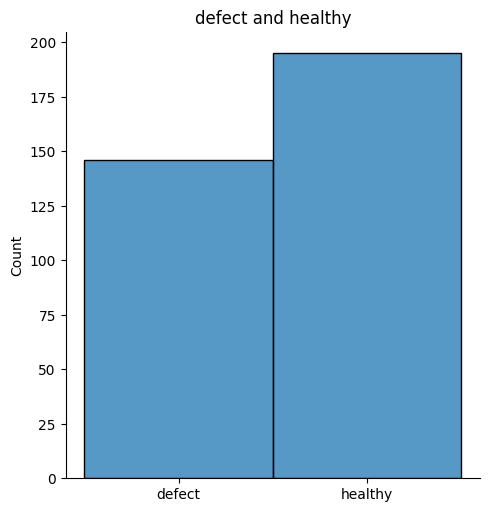

In [12]:
def plot_image_list_count(data_image_list, file_name):
    labels = []
    for img in data_image_list:
        labels.append(img.split('-')[0])
    sns_hist = sns.displot(labels)
    sns_hist.savefig(SAVING_DIR + file_name)
    plt.title('defect and healthy')
    
plot_image_list_count(train_image_list, 'train_defect_healthy_histogram')

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

In [13]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 341/341 [00:03<00:00, 101.42it/s]


Then, we plot the image selection.

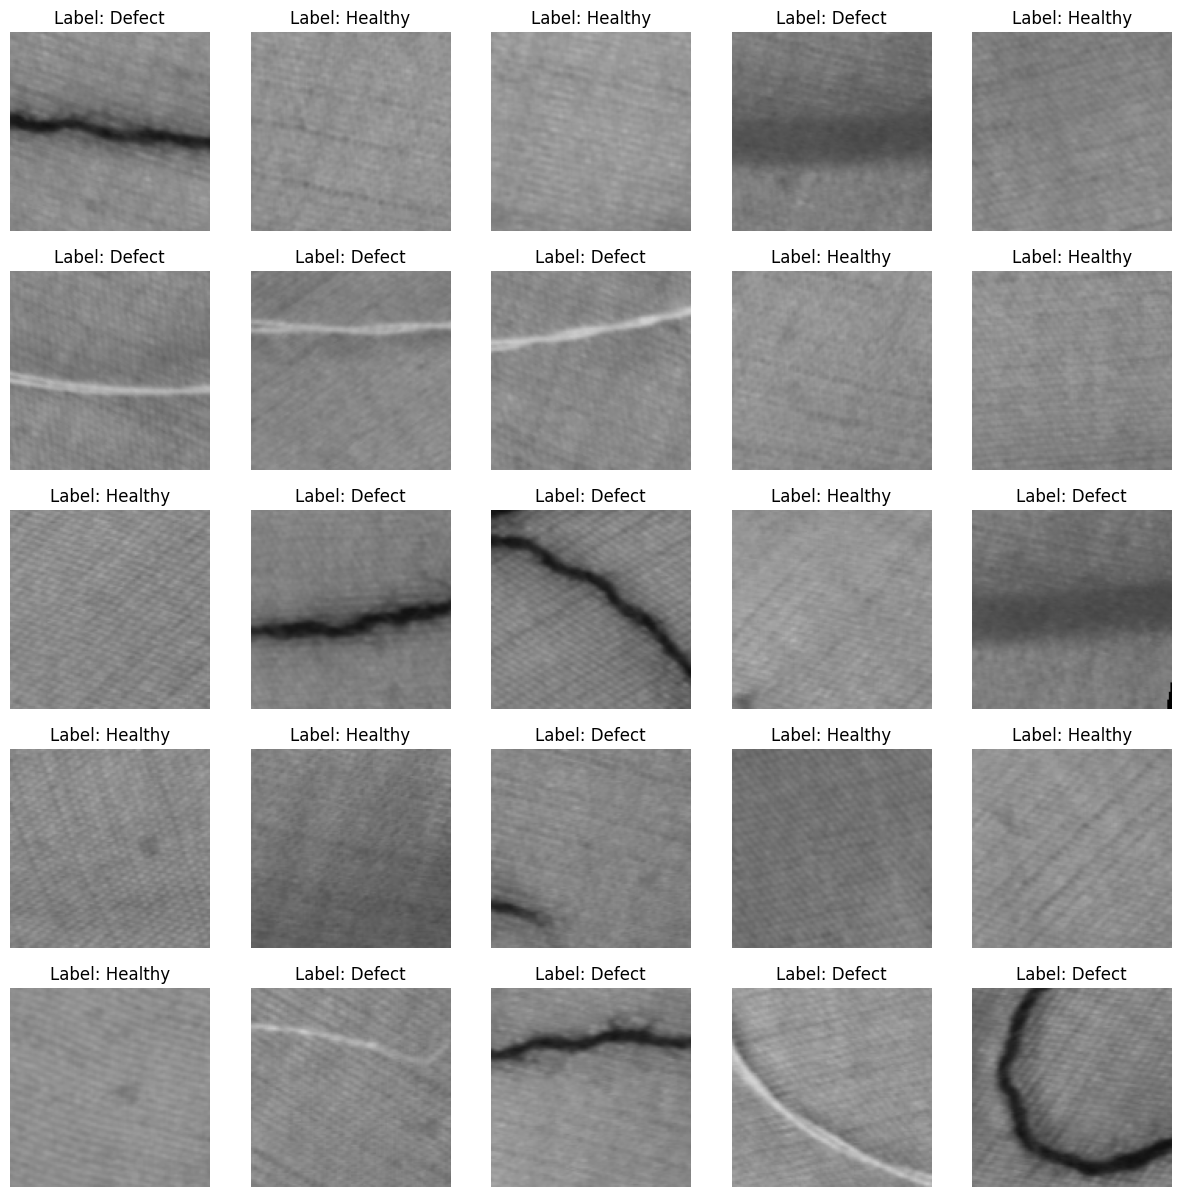

In [14]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Healthy'
        elif label == 0: 
            str_label='Defect'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    file_name = ''
    if isTest:
      file_name = 'test_images_without_predicted_class.png'
    else:
      file_name = 'train_images_with_class.png'
    plt.ion()
    plt.savefig(SAVING_DIR + file_name)

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [15]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 110/110 [00:23<00:00,  4.59it/s]


Then, we show a selection of the test set.

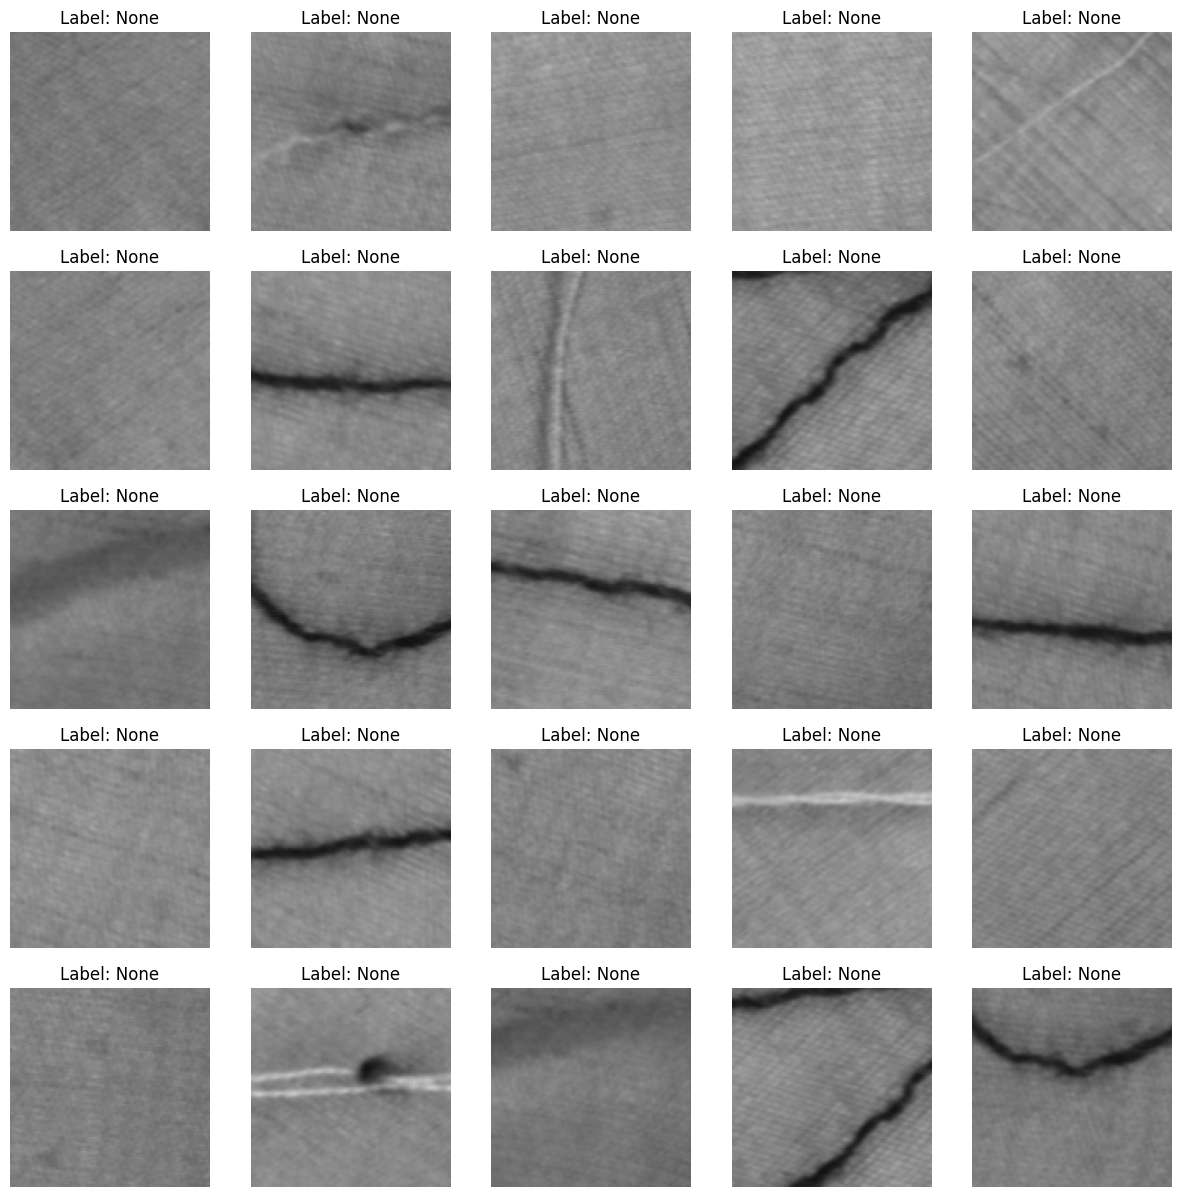

In [16]:
show_images(test,True)

# <a id="5">Model</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [17]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

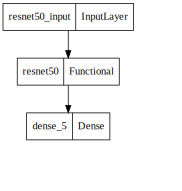

In [30]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  validation_data=(X_val, y_val))

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

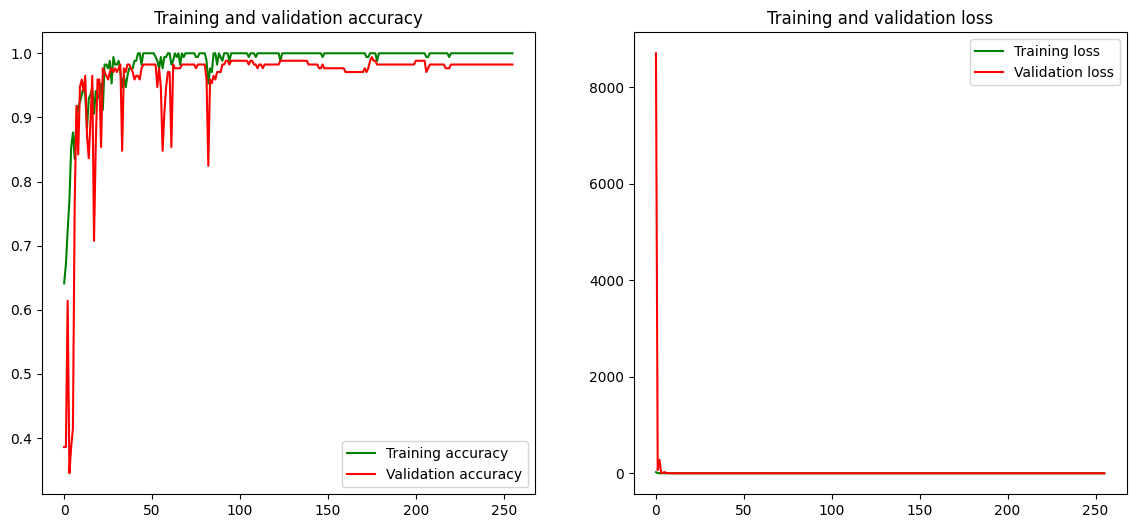

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.ion()
    plt.savefig(SAVING_DIR + 'plot_accuracy_and_loss.png')

plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [29]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])


Validation loss: 0.04136795923113823
Validation accuracy: 0.988304078578949


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [23]:
#get the predictions for the test data
predicted_classes = model.predict(X_val)
predicted_classes = np.argmax(predicted_classes,axis=1)

#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

6/6 [==============================] - 0s 41ms/step


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [25]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [26]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.98      0.98      0.98        65
    Class 1:       0.99      0.99      0.99       106

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



# <a id="6">Prepare the submission</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


1/1 [==============================] - 0s 25ms/step


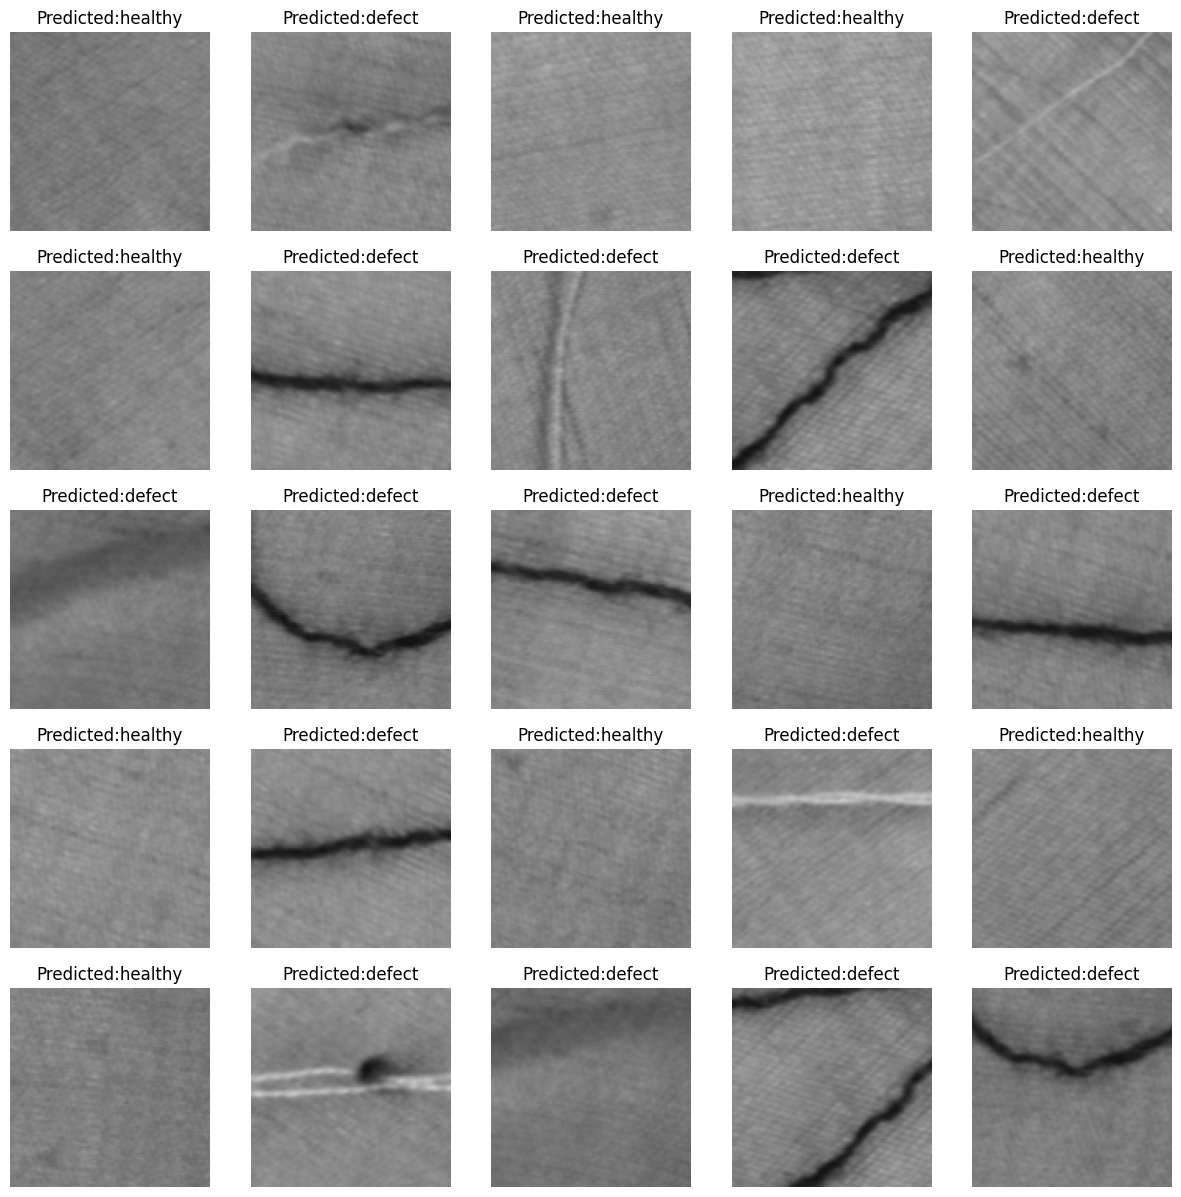

In [27]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='healthy'
    else: 
        str_predicted='defect'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))
plt.ion()
plt.savefig(SAVING_DIR + 'test_images_with_predicted_class.png')


# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  
